In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.metrics import mean_squared_error

In [237]:
df_train = pd.read_csv('~/Downloads/busn41204-winter23-homework-4/housing_train.csv')
df_test = pd.read_csv('~/Downloads/busn41204-winter23-homework-4/housing_test.csv')

df_test.head()
df_train['Sale_Price'] = np.log(df_train['Sale_Price'])

In [212]:
# separate the features and target
X = df_train.iloc[:, :99]
y = df_train.iloc[:, 99]

# perform PCA analysis
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X)

# get the explained variance ratio of the components
explained_variance = pca.explained_variance_ratio_

# select the best features
selector = SelectKBest(f_regression, k=63)
X_best = selector.fit_transform(X_pca, y)

# fit the linear regression model
reg = LinearRegression()
reg.fit(X_best, y)

# check the R^2 score
print('R^2 score:', reg.score(X_best, y))

R^2 score: 0.8902015921885533


In [213]:
# separate the features
X2 = df_test.iloc[:, :99]

# perform PCA analysis on the second dataframe
X2_pca = pca.transform(X2)

# select the best features from the second dataframe
X2_best = selector.transform(X2_pca)

# use the fitted linear regression model to predict the 'Sale_Price'
y_pred = reg.predict(X2_best)

# return the prediction result in a pandas Series
result = np.exp(pd.Series(y_pred, name='Sale_Price'))


# write the result to an Excel file
result.to_csv('prediction_result_lin.csv', index=False)


In [214]:
result


0      263679.215215
1      195600.000404
2      188317.348358
3      182848.648311
4      198666.129000
           ...      
871    102572.802230
872     90890.877174
873     85018.120136
874    162046.909766
875    153527.382325
Name: Sale_Price, Length: 876, dtype: float64

# Boruta

In [80]:
# from xgboost import XGBRegressor

# # separate the features and target
# X = df_train.iloc[:, :99]
# y = df_train.iloc[:, 99]

# # perform PCA analysis
# pca = PCA(n_components=None)
# X_pca = pca.fit_transform(X)

# # select the best features
# selector = SelectKBest(f_regression, k=63)
# X_best = selector.fit_transform(X_pca, y)

# # fit the XGBoost model
# xgb = XGBRegressor()
# xgb.fit(X_best, y)

# # separate the features
# X2 = df_test.iloc[:, :99]

# # perform PCA analysis on the second dataframe
# X2_pca = pca.transform(X2)

# # select the best features from the second dataframe
# X2_best = selector.transform(X2_pca)

# # use the fitted XGBoost model to predict the 'Sale_Price'
# y_pred = xgb.predict(X2_best)

# # return the prediction result in a pandas Series
# result = np.exp(pd.Series(y_pred, name='Sale_Price'))

# # write the result to a CSV file
# result.to_csv('prediction_result.csv', index=False)


In [47]:
################ actual homework

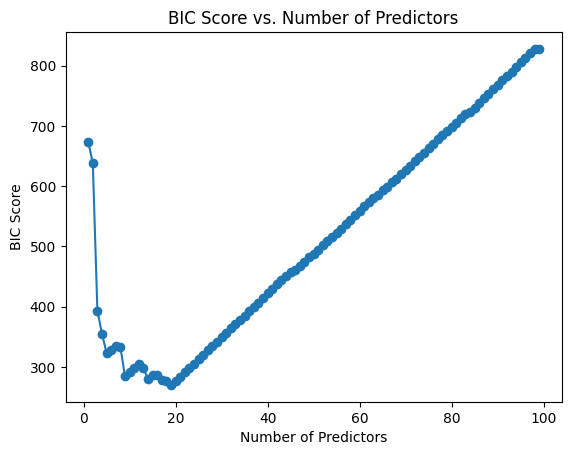

Number of variables selected by BIC: 19


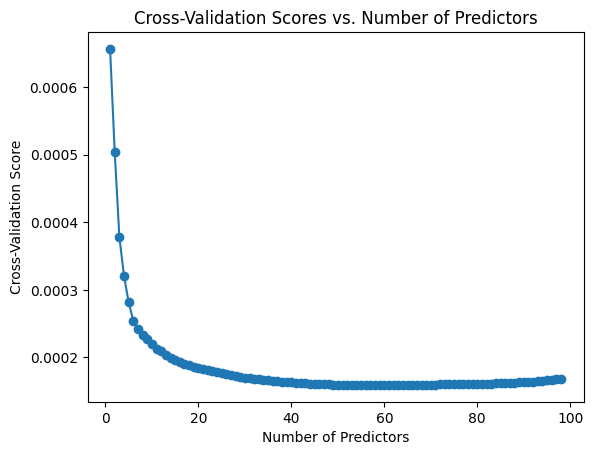

Number of variables selected by Cross-Validation: 61


AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [241]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

df = df_train.copy()

# Calculate BIC scores
X = df.iloc[:, :99]
y = df.iloc[:, 99]

reg = LinearRegression()
kf = KFold(n_splits=10)
bic_scores = []

for num_predictors in range(1, 100):
    X_subset = X.iloc[:, :num_predictors]
    
    log_likelihood = -np.sum((y - reg.fit(X_subset, y).predict(X_subset))**2)
    bic = -2 * log_likelihood + num_predictors * np.log(len(y))
    bic_scores.append(bic)

plt.plot(range(1, 100), bic_scores, marker='o')
plt.xlabel('Number of Predictors')
plt.ylabel('BIC Score')
plt.title('BIC Score vs. Number of Predictors')
plt.show()

best_num_predictors_bic = np.argmin(bic_scores) + 1
print('Number of variables selected by BIC:', best_num_predictors_bic)

X = df_train.iloc[:, :-2].values
y = np.log(df_train.iloc[:, -1].values)

selected_features = []
remaining_features = list(range(X.shape[1]))
cv_scores = []

while remaining_features:
    scores_with_candidates = []
    for candidate in remaining_features:
        feature_set = selected_features + [candidate]
        X_train = X[:, feature_set]
        
        reg = LinearRegression()
        cv = np.mean(-cross_val_score(reg, X_train, y, cv=5, scoring="neg_mean_squared_error"))
        scores_with_candidates.append((cv, candidate))
        
    scores_with_candidates.sort()
    best_candidate = scores_with_candidates[0][1]
    selected_features.append(best_candidate)
    remaining_features.remove(best_candidate)
    cv_scores.append(scores_with_candidates[0][0])
    
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
plt.xlabel('Number of Predictors')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Scores vs. Number of Predictors')
plt.show()

print('Number of variables selected by Cross-Validation:', cv_scores.index(min(cv_scores))+1)

# sd = np.std(reg.coef_)
# selected_features = [i for i, coef in enumerate(reg.coef_) if np.abs(coef) > sd]

# X_train = X[:, selected_features]


In [242]:
reg = LinearRegression()
reg.fit(X, y)

sd = np.std(reg.coef_)
selected_features = [i for i, coef in enumerate(reg.coef_) if np.abs(coef) > sd]
X_train = X[:, selected_features]
cv = np.mean(-cross_val_score(reg, X_train, y, cv=5, scoring="neg_mean_squared_error"))

print('Number of variables selected by 1-SD Rule:', len(selected_features))



Number of variables selected by 1-SD Rule: 8


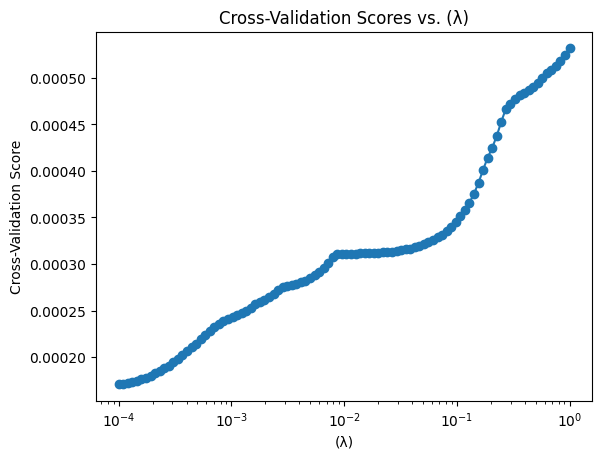

Number of variables selected by Cross-Validation: 70


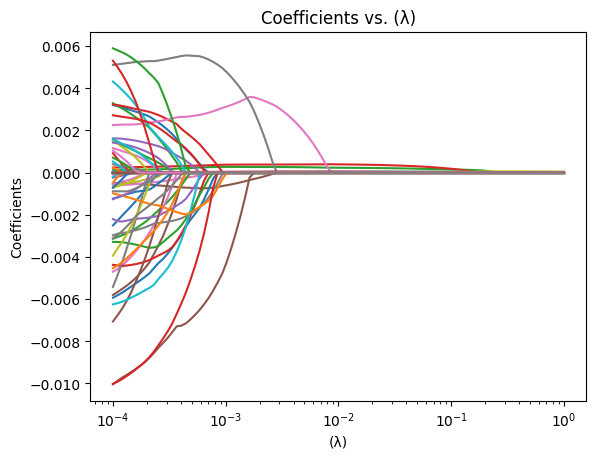

Number of variables selected by 1-SD Rule: 11


In [243]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt

df = df_train.copy()

# Calculate cross validation scores
X = df_train.iloc[:, :-2].values
y = np.log(df_train.iloc[:, -1].values)

lasso = Lasso(fit_intercept=True)
kf = KFold(n_splits=10)

# Create a plot displaying the cross validation score as a function of λ
cv_scores = []
alphas = np.logspace(-4, 0, num=100)

for alpha in alphas:
    lasso.alpha = alpha
    cv_scores.append(np.mean(-cross_val_score(lasso, X, y, cv=kf, scoring="neg_mean_squared_error")))

plt.plot(alphas, cv_scores, marker='o')
plt.xscale("log")
plt.xlabel('(λ)')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Scores vs. (λ)')
plt.show()

# Determine the number of variables selected by cross-validation
best_alpha = alphas[np.argmin(cv_scores)]
lasso.alpha = best_alpha
lasso.fit(X, y)
num_selected_by_cv = np.sum(lasso.coef_ != 0)
print('Number of variables selected by Cross-Validation:', num_selected_by_cv)

# Create a plot displaying the coefficient values as a function of λ
coefs = []
for alpha in alphas:
    lasso.alpha = alpha
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

plt.plot(alphas, coefs)
plt.xscale("log")
plt.xlabel('(λ)')
plt.ylabel('Coefficients')
plt.title('Coefficients vs. (λ)')
plt.show()

# Determine the number of variables selected by the 1-sd rule
mean = np.mean(coefs, axis=0)
std = np.std(coefs, axis=0)
num_selected_by_1sd = np.sum(np.abs(mean) > std)
print('Number of variables selected by 1-SD Rule:', num_selected_by_1sd)


In [244]:
df_train

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,First_Flr_SF,Low_Qual_Fin_SF,...,Garage_Finish_other,Paved_Drive_other,Pool_QC_other,Fence_No_Fence,Fence_other,Misc_Feature_other,Sale_Type_other,Sale_Condition_other,Gr_Liv_Area,Sale_Price
0,141,31770,1960,1960,112,2,0,441,1656,0,...,0,1,0,1,0,0,0,0,1656,12.278393
1,80,11622,1961,1961,0,6,144,270,896,0,...,0,0,0,0,0,0,0,0,896,11.561716
2,81,14267,1958,1958,108,1,0,406,1329,0,...,0,0,0,1,0,1,0,0,1329,12.055250
3,78,9978,1998,1998,20,3,0,324,926,0,...,0,0,0,1,0,0,0,0,1604,12.183316
4,41,4920,2001,2001,0,3,0,722,1338,0,...,0,0,0,1,0,0,0,0,1338,12.271392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,160,20000,1960,1996,0,1,0,0,1224,0,...,0,0,0,1,0,0,0,1,1224,11.782953
2045,0,8885,1983,1983,0,2,324,239,902,0,...,0,0,0,0,0,0,0,0,902,11.782953
2046,62,10441,1992,1992,0,3,0,575,970,0,...,1,0,0,0,0,1,0,0,970,11.790557
2047,77,10010,1974,1975,0,1,123,195,1389,0,...,0,0,0,1,0,0,0,0,1389,12.043554


In [418]:
df_train = pd.read_csv('~/Downloads/busn41204-winter23-homework-4/housing_train.csv')
df_test = pd.read_csv('~/Downloads/busn41204-winter23-homework-4/housing_test.csv')

df_test.head()
df_train['Sale_Price'] = np.log(df_train['Sale_Price'])
df = df_train.copy()

In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df_train.copy()

for i in range(99):
    if len(df[df.columns[i]].unique()) > 10:
        df_tmp = pd.DataFrame(data={'Z-Score': (df[df.columns[i]] - df[df.columns[i]].mean()) / df[df.columns[i]].std()})

#         plt.scatter(df_tmp.index, df_tmp['Z-Score'], s=5)
#         plt.xlabel('Data Point Index')
#         plt.ylabel('Z-Score')
#         plt.title(df.columns[i])
#         plt.show()
        
        outliers = df_tmp[df_tmp['Z-Score'] > 10].index

        for j in outliers:
            df.at[j, df.columns[i]] = df[df.columns[i]].mean() + 10 * df[df.columns[i]].std()


In [420]:
cols_in_df = set(df.columns)
cols_in_df_test = set(df_test.columns)

cols_not_in_df_test = cols_in_df - cols_in_df_test

print(f"Columns in df but not in df_test: {cols_not_in_df_test}")


Columns in df but not in df_test: {'Sale_Price'}


# Check if there are variables that are almosts not correlated with price

In [421]:
corr = df.corr()[df.columns[-1]]
corr = corr.abs().sort_values()
least_predictive = corr[:20].index

df_corr = pd.DataFrame({"Variable": least_predictive, "Correlation": corr[:20].values})
df_corr

# Kick out the worst ones
corr = df.corr()[df.columns[-1]]

corr_filtered = corr[corr.abs() > 0.05]
corr_filtered_out = corr[corr.abs() < 0.05]

keep_vars = corr_filtered.index

df = df[keep_vars]

df_test = df_test[keep_vars[0:-1]]
print('We get rid of the followinig variables: ',corr_filtered_out)

We get rid of the followinig variables:  BsmtFin_SF_2             0.015585
Low_Qual_Fin_SF         -0.045317
Bsmt_Half_Bath          -0.029952
Misc_Val                -0.022021
Mo_Sold                  0.031952
Year_Sold               -0.010675
MS_Zoning_other          0.001415
Land_Contour_other       0.047495
Land_Slope_other         0.046679
Condition_2_other        0.017977
House_Style_One_Story   -0.008414
Roof_Style_other        -0.032385
Pool_QC_other            0.037329
Name: Sale_Price, dtype: float64


# Check if there are any variables that are highly correlated to each other

In [422]:
cols_in_df = set(df.columns)
cols_in_df_test = set(df_test.columns)

cols_not_in_df_test = cols_in_df - cols_in_df_test

print(f"Columns in df but not in df_test: {cols_not_in_df_test}")


Columns in df but not in df_test: {'Sale_Price'}


In [423]:
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Get the 10 highest correlations
high_corr = (upper.stack().sort_values(ascending=False).to_frame('correlation').reset_index().rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2'}))[:10]
print(high_corr)


            feature_1             feature_2  correlation
0       TotRms_AbvGrd           Gr_Liv_Area     0.811637
1         Gr_Liv_Area            Sale_Price     0.712178
2    Bsmt_Exposure_No   Bsmt_Exposure_other     0.701585
3  Exter_Qual_Typical  Kitchen_Qual_Typical     0.676143
4       Bedroom_AbvGr         TotRms_AbvGrd     0.664224
5         Garage_Area            Sale_Price     0.664221
6        First_Flr_SF            Sale_Price     0.638792
7           Full_Bath           Gr_Liv_Area     0.631618
8          Year_Built     Bsmt_Qual_Typical     0.620110
9          Year_Built            Sale_Price     0.613785


/var/folders/qq/49c7wn95361bnbqw04zdw3j40000gn/T/ipykernel_20738/2895977252.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


df

In [424]:
cols_in_df = set(df.columns)
cols_in_df_test = set(df_test.columns)

cols_not_in_df_test = cols_in_df - cols_in_df_test

print(f"Columns in df but not in df_test: {cols_not_in_df_test}")


Columns in df but not in df_test: {'Sale_Price'}


In [425]:
to_encode = []
col_unique_counts = []

for col in df.columns[0:-1]:
    unique_count = df[col].nunique()
    if unique_count < 10:
        to_encode.append(col)
        col_unique_counts.append(unique_count)

col_unique_df = pd.DataFrame({'Column Name': to_encode, 'Unique Count': col_unique_counts})
print(col_unique_df)

# perform one-hot encoding on the columns that need it
to_encode
df = pd.get_dummies(df, columns=to_encode, prefix=to_encode)


             Column Name  Unique Count
0           BsmtFin_SF_1             7
1         Bsmt_Full_Bath             4
2              Full_Bath             5
3              Half_Bath             3
4          Bedroom_AbvGr             7
..                   ...           ...
64        Fence_No_Fence             2
65           Fence_other             2
66    Misc_Feature_other             2
67       Sale_Type_other             2
68  Sale_Condition_other             2

[69 rows x 2 columns]


In [426]:
to_encode = []
col_unique_counts = []

for col in df_test.columns[0:-1]:
    unique_count = df_test[col].nunique()
    if unique_count < 10:
        to_encode.append(col)
        col_unique_counts.append(unique_count)

col_unique_df_test = pd.DataFrame({'Column Name': to_encode, 'Unique Count': col_unique_counts})
print(col_unique_df_test)

# perform one-hot encoding on the columns that need it
df_test = pd.get_dummies(df_test, columns=to_encode, prefix=to_encode)

             Column Name  Unique Count
0           BsmtFin_SF_1             8
1         Bsmt_Full_Bath             3
2              Full_Bath             4
3              Half_Bath             3
4          Bedroom_AbvGr             8
..                   ...           ...
65        Fence_No_Fence             2
66           Fence_other             2
67    Misc_Feature_other             2
68       Sale_Type_other             2
69  Sale_Condition_other             2

[70 rows x 2 columns]


In [427]:
df_sale_price = df['Sale_Price'].copy()
cols_in_df = set(df.columns)
cols_in_df_test = set(df_test.columns)

cols_not_in_df_test = cols_in_df_test - cols_in_df
cols_not_in_df = cols_in_df - cols_in_df_test

print(f"Columns in df but not in df_test: {cols_not_in_df_test}")
print(f"Columns in df_test but not in df: {cols_not_in_df}")

# remove columns that are only in one of the dataframes
df.drop(columns=cols_not_in_df, inplace=True)
df_test.drop(columns=cols_not_in_df_test, inplace=True)


Columns in df but not in df_test: {'Three_season_porch_219', 'Three_season_porch_174', 'Three_season_porch_150', 'Three_season_porch_140', 'Three_season_porch_224', 'BsmtFin_SF_1_0', 'Three_season_porch_180', 'Three_season_porch_0', 'Bedroom_AbvGr_8'}
Columns in df_test but not in df: {'Utilities_other_1', 'Three_season_porch', 'Sale_Price', 'Kitchen_AbvGr_0', 'Bsmt_Full_Bath_3', 'Fireplaces_4', 'Full_Bath_4'}


In [428]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the data into a pandas dataframe and select the predictors and the response variable
X = df.iloc[:, :]
y = df_sale_price

# Perform PCA on the predictors
pca = PCA()
pca.fit(X)

# Get the first 50 components that explain the most variance
n = 50
X_reduced = pca.transform(X)[:, :n]


# Print the most important features
features = X.columns
importances = np.abs(pca.components_[0])
indices = np.argsort(importances)[::-1]
most_important_features = [features[i] for i in indices[:n]]
print("The most important 50 features are:")
print(most_important_features)


The most important 50 features are:
['Lot_Area', 'Gr_Liv_Area', 'First_Flr_SF', 'Garage_Area', 'Mas_Vnr_Area', 'Bsmt_Unf_SF', 'Wood_Deck_SF', 'Open_Porch_SF', 'Lot_Frontage', 'Screen_Porch', 'Enclosed_Porch', 'Year_Built', 'Year_Remod_Add', 'TotRms_AbvGrd', 'MS_SubClass_other_1', 'MS_SubClass_other_0', 'Bldg_Type_other_1', 'Bldg_Type_other_0', 'Fireplaces_0', 'MS_Zoning_Residential_Medium_Density_0', 'MS_Zoning_Residential_Medium_Density_1', 'Bsmt_Exposure_No_0', 'Bsmt_Exposure_No_1', 'Garage_Type_Detchd_0', 'Garage_Type_Detchd_1', 'Bsmt_Exposure_other_1', 'Bsmt_Exposure_other_0', 'Fireplaces_2', 'Lot_Shape_Slightly_Irregular_0', 'Lot_Shape_Slightly_Irregular_1', 'Bedroom_AbvGr_2', 'Full_Bath_1', 'Lot_Config_Inside_0', 'Lot_Config_Inside_1', 'Roof_Style_Hip_1', 'Roof_Style_Hip_0', 'Lot_Config_other_1', 'Lot_Config_other_0', 'Bedroom_AbvGr_4', 'Lot_Shape_other_1', 'Lot_Shape_other_0', 'Full_Bath_2', 'Bsmt_Full_Bath_0', 'Fireplace_Qu_Typical_1', 'Fireplace_Qu_Typical_0', 'Kitchen_Qual_Ty

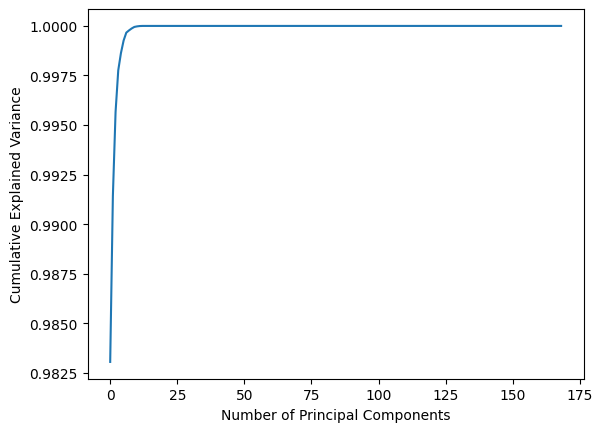

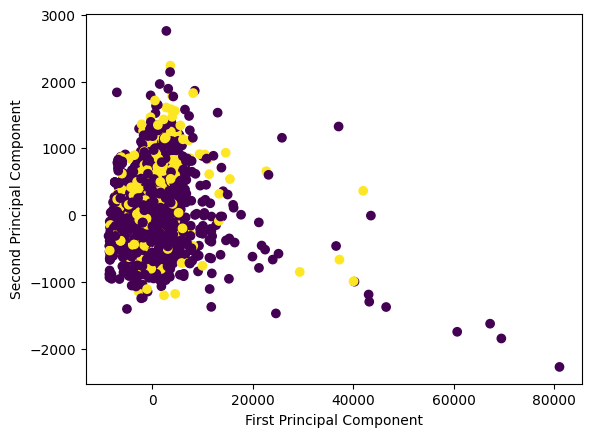

The most important 50 features are:
['Lot_Area', 'Gr_Liv_Area', 'First_Flr_SF', 'Garage_Area', 'Mas_Vnr_Area', 'Bsmt_Unf_SF', 'Wood_Deck_SF', 'Open_Porch_SF', 'Lot_Frontage', 'Screen_Porch', 'Enclosed_Porch', 'Year_Built', 'Year_Remod_Add', 'TotRms_AbvGrd', 'MS_SubClass_other_0', 'MS_SubClass_other_1', 'Bldg_Type_other_1', 'Bldg_Type_other_0', 'Fireplaces_0', 'MS_Zoning_Residential_Medium_Density_0', 'MS_Zoning_Residential_Medium_Density_1', 'Bsmt_Exposure_No_0', 'Bsmt_Exposure_No_1', 'Garage_Type_Detchd_1', 'Garage_Type_Detchd_0', 'Bsmt_Exposure_other_1', 'Bsmt_Exposure_other_0', 'Fireplaces_2', 'Lot_Shape_Slightly_Irregular_1', 'Lot_Shape_Slightly_Irregular_0', 'Bedroom_AbvGr_2', 'Full_Bath_1', 'Lot_Config_Inside_1', 'Lot_Config_Inside_0', 'Roof_Style_Hip_1', 'Roof_Style_Hip_0', 'Lot_Config_other_1', 'Lot_Config_other_0', 'Bedroom_AbvGr_4', 'Lot_Shape_other_0', 'Lot_Shape_other_1', 'Full_Bath_2', 'Bsmt_Full_Bath_0', 'Fireplace_Qu_Typical_0', 'Fireplace_Qu_Typical_1', 'Kitchen_Qual_Ty

In [429]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the data into a pandas dataframe and select the predictors and the response variable
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Perform PCA on the predictors
pca = PCA()
pca.fit(X)

# Plot the explained variance ratio by each principal component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Get the first 50 components that explain the most variance
n = 50
X_reduced = pca.transform(X)[:, :n]

# Plot the first two components against the response variable
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Print the most important features
features = X.columns
importances = np.abs(pca.components_[0])
indices = np.argsort(importances)[::-1]
most_important_features = [features[i] for i in indices[:n]]
print("The most important 50 features are:")
print(most_important_features)


# Testing

In [387]:
# Load the test data into a pandas dataframe

# Select the predictors and the response variable
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# Perform PCA on the predictors
pca = PCA()
pca.fit(X_test)

# Get the first n components that explain the most variance
n = 50
X_test_reduced = pca.transform(X_test)[:, :n]

# Make predictions using the reduced predictors
y_pred = model.predict(X_test_reduced)

# Evaluate the predictions
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


NameError: name 'model' is not defined

In [430]:
df['Sale_Price'] = df_sale_price
df

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Bsmt_Unf_SF,First_Flr_SF,TotRms_AbvGrd,Garage_Area,Wood_Deck_SF,...,Fence_No_Fence_1,Fence_other_0,Fence_other_1,Misc_Feature_other_0,Misc_Feature_other_1,Sale_Type_other_0,Sale_Type_other_1,Sale_Condition_other_0,Sale_Condition_other_1,Sale_Price
0,141,31770.0,1960,1960,112,441,1656,7,528,210.0,...,1,1,0,1,0,1,0,1,0,12.278393
1,80,11622.0,1961,1961,0,270,896,5,730,140.0,...,0,1,0,1,0,1,0,1,0,11.561716
2,81,14267.0,1958,1958,108,406,1329,6,312,393.0,...,1,1,0,0,1,1,0,1,0,12.055250
3,78,9978.0,1998,1998,20,324,926,7,470,360.0,...,1,1,0,1,0,1,0,1,0,12.183316
4,41,4920.0,2001,2001,0,722,1338,6,582,0.0,...,1,1,0,1,0,1,0,1,0,12.271392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,160,20000.0,1960,1996,0,0,1224,7,576,474.0,...,1,1,0,1,0,1,0,0,1,11.782953
2045,0,8885.0,1983,1983,0,239,902,5,484,164.0,...,0,1,0,1,0,1,0,1,0,11.782953
2046,62,10441.0,1992,1992,0,575,970,6,0,80.0,...,0,1,0,0,1,1,0,1,0,11.790557
2047,77,10010.0,1974,1975,0,195,1389,6,418,240.0,...,1,1,0,1,0,1,0,1,0,12.043554


In [433]:
from xgboost import XGBRegressor

# separate the features and target
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# perform PCA analysis
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X)

# select the best features
selector = SelectKBest(f_regression, k=50)
X_best = selector.fit_transform(X_pca, y)

# fit the XGBoost model
xgb = XGBRegressor()
xgb.fit(X_best, y)

# separate the features
X2 = df_test.iloc[:,:]

# perform PCA analysis on the second dataframe
X2_pca = pca.transform(X2)

# select the best features from the second dataframe
X2_best = selector.transform(X2_pca)

# use the fitted XGBoost model to predict the 'Sale_Price'
y_pred = xgb.predict(X2_best)

# return the prediction result in a pandas Series
result = np.exp(pd.Series(y_pred, name='Sale_Price'))

# write the result to a CSV file
result.to_csv('prediction_result.csv', index=False)

0       0
1       0
2       0
3       0
4       0
       ..
2044    1
2045    0
2046    0
2047    0
2048    0
Name: Sale_Condition_other_1, Length: 2049, dtype: uint8

In [398]:
df

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Bsmt_Unf_SF,First_Flr_SF,TotRms_AbvGrd,Garage_Area,Wood_Deck_SF,...,Fence_No_Fence_0,Fence_No_Fence_1,Fence_other_0,Fence_other_1,Misc_Feature_other_0,Misc_Feature_other_1,Sale_Type_other_0,Sale_Type_other_1,Sale_Condition_other_0,Sale_Condition_other_1
0,141,31770.0,1960,1960,112,441,1656,7,528,210.0,...,0,1,1,0,1,0,1,0,1,0
1,80,11622.0,1961,1961,0,270,896,5,730,140.0,...,1,0,1,0,1,0,1,0,1,0
2,81,14267.0,1958,1958,108,406,1329,6,312,393.0,...,0,1,1,0,0,1,1,0,1,0
3,78,9978.0,1998,1998,20,324,926,7,470,360.0,...,0,1,1,0,1,0,1,0,1,0
4,41,4920.0,2001,2001,0,722,1338,6,582,0.0,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,160,20000.0,1960,1996,0,0,1224,7,576,474.0,...,0,1,1,0,1,0,1,0,0,1
2045,0,8885.0,1983,1983,0,239,902,5,484,164.0,...,1,0,1,0,1,0,1,0,1,0
2046,62,10441.0,1992,1992,0,575,970,6,0,80.0,...,1,0,1,0,0,1,1,0,1,0
2047,77,10010.0,1974,1975,0,195,1389,6,418,240.0,...,0,1,1,0,1,0,1,0,1,0


In [414]:
X

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,Bsmt_Unf_SF,First_Flr_SF,TotRms_AbvGrd,Garage_Area,Wood_Deck_SF,...,Fence_No_Fence_0,Fence_No_Fence_1,Fence_other_0,Fence_other_1,Misc_Feature_other_0,Misc_Feature_other_1,Sale_Type_other_0,Sale_Type_other_1,Sale_Condition_other_0,Sale_Condition_other_1
0,141,31770.0,1960,1960,112,441,1656,7,528,210.0,...,0,1,1,0,1,0,1,0,1,0
1,80,11622.0,1961,1961,0,270,896,5,730,140.0,...,1,0,1,0,1,0,1,0,1,0
2,81,14267.0,1958,1958,108,406,1329,6,312,393.0,...,0,1,1,0,0,1,1,0,1,0
3,78,9978.0,1998,1998,20,324,926,7,470,360.0,...,0,1,1,0,1,0,1,0,1,0
4,41,4920.0,2001,2001,0,722,1338,6,582,0.0,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,160,20000.0,1960,1996,0,0,1224,7,576,474.0,...,0,1,1,0,1,0,1,0,0,1
2045,0,8885.0,1983,1983,0,239,902,5,484,164.0,...,1,0,1,0,1,0,1,0,1,0
2046,62,10441.0,1992,1992,0,575,970,6,0,80.0,...,1,0,1,0,0,1,1,0,1,0
2047,77,10010.0,1974,1975,0,195,1389,6,418,240.0,...,0,1,1,0,1,0,1,0,1,0


In [415]:
y

[0       12.278393
 1       11.561716
 2       12.055250
 3       12.183316
 4       12.271392
           ...    
 2044    11.782953
 2045    11.782953
 2046    11.790557
 2047    12.043554
 2048    12.144197
 Name: Sale_Price, Length: 2049, dtype: float64]

# check for overfitting

In [449]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

zs = []
rmses = []
for zz in range(5,50,2):
    # separate the features and target
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    # Split the data into 80% train and 20% test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # perform PCA analysis on the training data
    pca = PCA(n_components=None)
    X_train_pca = pca.fit_transform(X_train)

    # select the best features from the training data
    selector = SelectKBest(f_regression, k=zz)
    X_train_best = selector.fit_transform(X_train_pca, y_train)

    # fit the XGBoost model on the training data
    xgb = XGBRegressor()
    xgb.fit(X_train_best, y_train)

    # perform PCA analysis on the test data
    X_test_pca = pca.transform(X_test)

    # select the best features from the test data
    X_test_best = selector.transform(X_test_pca)

    # use the fitted XGBoost model to predict the 'Sale_Price' on the test data
    y_pred = xgb.predict(X_test_best)

    # evaluate the performance of the model using mean squared error and R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Number of features: {zz:.4f}")
    zs.append(zz)
    print(f"Mean Squared Error: {mse:.4f}")
    rmses.append(mse)
    print(f"R-squared: {r2:.4f}")

    # # separate the features of the second dataframe
    # X2 = df_test.iloc[:,:]

    # # perform PCA analysis on the second dataframe
    # X2_pca = pca.transform(X2)

    # # select the best features from the second dataframe
    # X2_best = selector.transform(X2_pca)

    # # use the fitted XGBoost model to predict the 'Sale_Price' on the second dataframe
    # y_pred = xgb.predict(X2_best)

    # # return the prediction result in a pandas Series
    # result = np.exp(pd.Series(y_pred, name='Sale_Price'))

    # # write the result to a CSV file
    # result.to_csv('prediction_result.csv', index=False)



ValueError: Found input variables with inconsistent numbers of samples: [410, 876]

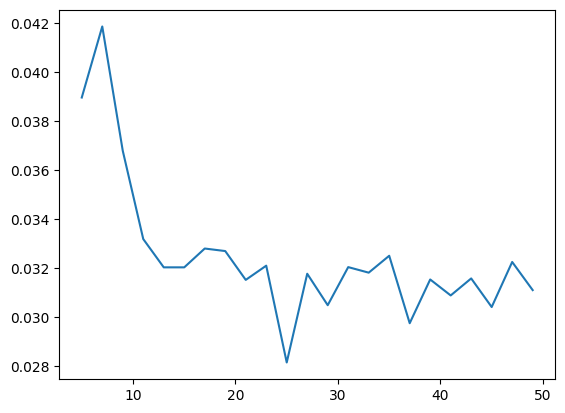

In [446]:
plt.plot(zs,rmses)
plt.show()

In [463]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

zs = []
rmses = []
for zz in range(1,100):
    print(zz)
    # separate the features and target
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    # Split the data into 80% train and 20% test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # perform PCA analysis on the training data
    pca = PCA(n_components=None)
    X_train_pca = pca.fit_transform(X_train)

    # select the best features from the training data
    selector = SelectKBest(f_regression, k=50)
    X_train_best = selector.fit_transform(X_train_pca, y_train)

    # fit the Lasso model on the training data
    lasso = Lasso(alpha=50/100000)
    lasso.fit(X_train_best, y_train)

    # perform PCA analysis on the test data
    X_test_pca = pca.transform(X_test)

    # select the best features from the test data
    X_test_best = selector.transform(X_test_pca)

    # use the fitted Lasso model to predict the 'Sale_Price' on the test data
    y_pred = lasso.predict(X_test_best)

    # evaluate the performance of the model using mean squared error and R-squared
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
#     print(f"Number of features: {zz:.4f}")
    zs.append(zz)
#     print(f"Mean Squared Error: {mse:.4f}")
    rmses.append(mse)
#     print(f"R-squared: {r2:.4f}")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


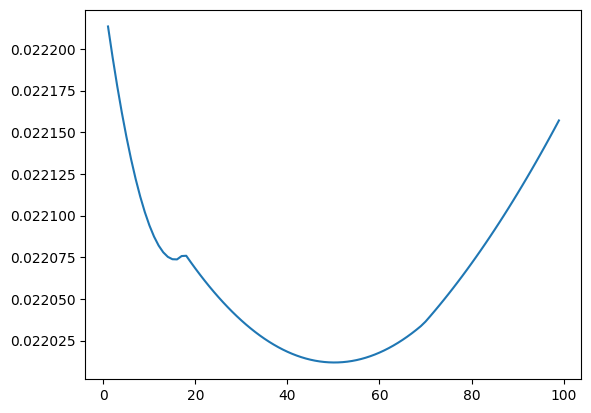

In [464]:
plt.plot(zs,rmses)
plt.show()

In [465]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

zs = []
rmses = []

# separate the features and target
X_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]

# perform PCA analysis on the training data
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train)

# select the best features from the training data
selector = SelectKBest(f_regression, k=50)
X_train_best = selector.fit_transform(X_train_pca, y_train)

# fit the Lasso model on the training data
lasso = Lasso(alpha=50/100000)
lasso.fit(X_train_best, y_train)

X_test = df_test

# perform PCA analysis on the test data
X_test_pca = pca.transform(X_test)

# select the best features from the test data
X_test_best = selector.transform(X_test_pca)

# use the fitted Lasso model to predict the 'Sale_Price' on the test data
y_pred = lasso.predict(X_test_best)

# return the prediction result in a pandas Series
result = np.exp(pd.Series(y_pred, name='Sale_Price'))

# write the result to a CSV file
result.to_csv('prediction_result.csv', index=False)

# #######

# # separate the features and target
# X = df.iloc[:,:-1]
# y = df.iloc[:,-1]

# # perform PCA analysis
# pca = PCA(n_components=None)
# X_pca = pca.fit_transform(X)

# # select the best features
# selector = SelectKBest(f_regression, k=50)
# X_best = selector.fit_transform(X_pca, y)

# # fit the XGBoost model
# xgb = XGBRegressor()
# xgb.fit(X_best, y)

# # separate the features
# X2 = df_test.iloc[:,:]

# # perform PCA analysis on the second dataframe
# X2_pca = pca.transform(X2)

# # select the best features from the second dataframe
# X2_best = selector.transform(X2_pca)

# # use the fitted XGBoost model to predict the 'Sale_Price'
# y_pred = xgb.predict(X2_best)

# # return the prediction result in a pandas Series
# result = np.exp(pd.Series(y_pred, name='Sale_Price'))

# # write the result to a CSV file
# result.to_csv('prediction_result.csv', index=False)